In [1]:
from utils import create_loaders, compute_distance, MAPE
from australian_data_utils import get_australian_data, create_model_loader_train_objects

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import copy

/home/ahmed/.conda/envs/pytorch_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_window = 36
horizon = 12

input_dimension = 1
hidden_dimension = 40
batch_size = 256

support_train_loader_dictionary = {}
support_validation_loader_dictionary = {}
support_train_object_dictionary = {}

query_train_loader_dictionary = {}
query_validation_loader_dictionary = {}
query_train_object_dictionary = {}


In [3]:
meta_support_austalian_data = [('NSW', '03'), ('NSW', '18'), ('QLD', '03'), ('QLD', '18'), ('SA', '03')]
meta_query_austalian_data = [('SA', '18'), ('TAS', '07'), ('TAS', '18'), ('VIC', '04'), ('VIC', '18')]


In [4]:
create_model_loader_train_objects(data=meta_support_austalian_data,
                                  train_loader_dictionary=support_train_loader_dictionary, 
                                  validation_loader_dictionary=support_validation_loader_dictionary,
                                  train_object_dictionary=support_train_object_dictionary,
                                  train_window=train_window, hidden_dimension=hidden_dimension, horizon=horizon, batch_size=batch_size,
                                  train_model=True, num_epochs=120)

1- creating objects from NSW on year 03
-----starting training-----
epoch 10 train loss 0.00481 ------ validation loss 0.00472
epoch 20 train loss 0.00474 ------ validation loss 0.00402
epoch 30 train loss 0.00372 ------ validation loss 0.00379
epoch 40 train loss 0.00313 ------ validation loss 0.00373
epoch 50 train loss 0.00272 ------ validation loss 0.00327
epoch 60 train loss 0.00325 ------ validation loss 0.00312
epoch 70 train loss 0.00269 ------ validation loss 0.00310
epoch 80 train loss 0.00346 ------ validation loss 0.00286
epoch 90 train loss 0.00261 ------ validation loss 0.00283
epoch 100 train loss 0.00318 ------ validation loss 0.00273
epoch 110 train loss 0.00286 ------ validation loss 0.00276
epoch 120 train loss 0.00265 ------ validation loss 0.00275
epoch 120 train loss 0.00265 ------ validation loss 0.00275
2- creating objects from NSW on year 18
-----starting training-----
epoch 10 train loss 0.00328 ------ validation loss 0.00412
epoch 20 train loss 0.00254 ------

In [5]:
create_model_loader_train_objects(data=meta_query_austalian_data,
                                  train_loader_dictionary=query_train_loader_dictionary, 
                                  validation_loader_dictionary=query_validation_loader_dictionary,
                                  train_object_dictionary=query_train_object_dictionary,
                                  train_window=train_window, hidden_dimension=hidden_dimension, horizon=horizon, batch_size=batch_size,
                                  train_model=False)

1- creating objects from SA on year 18
2- creating objects from TAS on year 07
3- creating objects from TAS on year 18
4- creating objects from VIC on year 04
5- creating objects from VIC on year 18


In [10]:
experiment_iteration_result = []
iteration_number = 10
for _ in range(iteration_number):
    distance_list = []
    for key, item in support_train_object_dictionary.items():
        distance_list.append(compute_distance(item.model, item.train_loader, query_train_object_dictionary['train_objectSA18'].train_loader, batch_size, batch_size))
        
    test_object_dictionary = {}
    for i, (k, v) in enumerate(support_train_object_dictionary.items()):
        test_object_dictionary[f'obejct{i+1}'] = copy.deepcopy(query_train_object_dictionary['train_objectSA18'])
        test_object_dictionary[f'obejct{i+1}'].model = v.model
        test_object_dictionary[f'obejct{i+1}'].train(num_epochs=1)
            
    mape_list = []
    mseloss_list = []
    for i, (k, v) in enumerate(support_train_object_dictionary.items()):

        inputs, target = next(enumerate(test_object_dictionary[f'obejct{i+1}'].train_loader, 0))[1]
        inputs = inputs.type(torch.float32).to(test_object_dictionary[f'obejct{i+1}'].learning_parmeters['device'])
        target = target.type(torch.float32).to(test_object_dictionary[f'obejct{i+1}'].learning_parmeters['device'])
        outputs = test_object_dictionary[f'obejct{i+1}'].model(inputs)
        with torch.no_grad():
            mseloss_list.append(nn.MSELoss()(target, outputs).item())
            mape_list.append(MAPE(target, outputs).mean().item())


    experiment_iteration_result.append([distance_list, mape_list, mseloss_list])

-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----
-----starting training-----


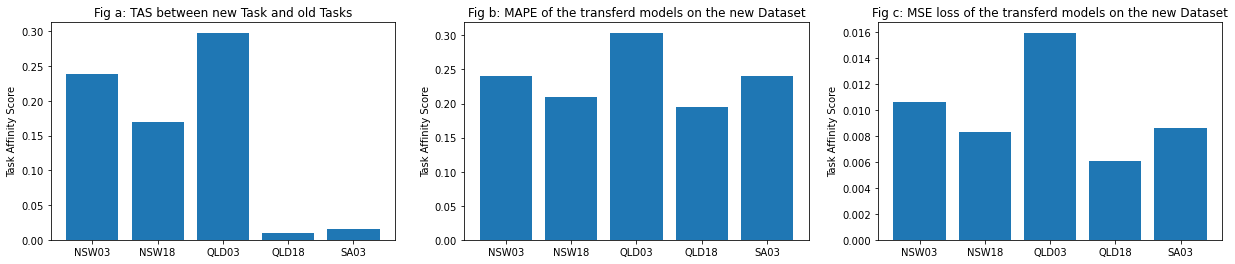

In [11]:
fig, axes = plt.subplots(1, 3,  figsize=(21, 4))
xlabel = [i+j for i, j in meta_support_austalian_data]
axes[0].bar(xlabel, distance_list)
axes[0].set_ylabel('Task Affinity Score')
axes[0].set_title('Fig a: TAS between new Task and old Tasks')

axes[1].bar(xlabel, mape_list)
axes[1].set_ylabel('Task Affinity Score')
axes[1].set_title('Fig b: MAPE of the transferd models on the new Dataset')

axes[2].bar(xlabel, mseloss_list)
axes[2].set_ylabel('Task Affinity Score')
axes[2].set_title('Fig c: MSE loss of the transferd models on the new Dataset')


plt.show()

In [14]:
from scipy.stats import pearsonr   
pearsonr(mseloss_list, distance_list)


PearsonRResult(statistic=0.8407945320950223, pvalue=0.07440767546229489)

5